# Section 3.3 — Introduction to hypothesis testing

This notebook contains the code examples from [Section 3.3 Introduction to hypothesis testing]() of the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={'figure.figsize': (7,4)},
)
blue, orange  = sns.color_palette()[0], sns.color_palette()[1]
red = sns.color_palette("tab10")[3]
DESTDIR = "figures/stats/NHST"

%config InlineBackend.figure_format = 'retina'

In [4]:
# set random seed for repeatability
np.random.seed(42)

## What is hypothesis testing?

- An approach to formulating research questions as **yes-no decisions** and a **procedure for making these decisions**
- Hypothesis testing is a standardized procedure for doing statistical analysis  
  (also, using stats jargon makes everything look more convincing ;)
- We formulate research question as two **competing hypotheses**:
  - **Null hypothesis $H_0$** = no effect.  
    In our example: "no difference between means," which can be written as $\color{red}{\mu_S = \mu_{NS} = \mu_0}$,
    means the probability models for the two groups have the same mean $\mu_0$:
    $$ 
       H_0: \qquad X_S = \mathcal{N}(\color{red}{\mu_0}, \sigma_S)
       \quad \textrm{and} \quad
       X_{NS} = \mathcal{N}(\color{red}{\mu_0}, \sigma_{NS}) \quad
    $$
  - **Alternative hypothesis $H_A$** = an effect exists.
    In our example: "the means for Group S is different from the mean of Group NS"
    can be written as $\color{blue}{\mu_S} \neq \color{orange}{\mu_{NS}}$.
    The probability models for the two groups with different means are:
    $$ 
       H_A: \qquad X_S = \mathcal{N}(\color{blue}{\mu_S}, \sigma_S)
       \quad \textrm{and} \quad
       X_{NS} = \mathcal{N}(\color{orange}{\mu_{NS}}, \sigma_{NS})
    $$
- The purpose of hypothesis testing is to perform a basic sanity-check to show the difference between the group means
  we observed ($d = \overline{\mathbf{x}}_{S} - \overline{\mathbf{x}}_{NS} = 130$) is **unlikely to have occurred by chance**.
- NEW CONCEPT: the $p$-value is the probability of observing $d=130$ (or more extreme) under the null hypothesis.

### Overview of the hypothesis testing procedure

Here is the high-level overview of the hypothesis testing procedure:
- **inputs**: sample statistics computed from the observed data
  (in our case the signal $\overline{\mathbf{x}}_S$, $\overline{\mathbf{x}}_{NS}$,
   and our estimates of the noise $s^2_S$, and $s^2_{NS}$)
- **outputs**: a decision that is one of: "reject the null hypothesis" or "fail to reject the null hypothesis"

![hypothesis testing overview](./attachments/stats/hypothesis_testing_perm_test.png)


We'll now look at two different approaches for computing the sampling distribution of
the difference between group means statistic, $D = \overline{\mathbf{X}}_S - \overline{\mathbf{X}}_{NS}$:
permutation tests and analytical approximations.

### Interpreting the result of a hypothesis test (optional)



- The implication of rejecting the null hypothesis (no difference) is that there must be a difference between the group means.
  In other words, the average ELV (employee lifetime value) for employees who took the statistics training (**Group S**) is different form
  the average ELV for employees who didn't take the statistics training (**Group NS**),
  which is what Amy is trying to show.
  - Note that rejecting null hypothesis ($H_0$) is not the same as "proving" the alternative hypothesis ($H_A$);
    we have just shown that the data is unlikely under the null hypothesis,
    so there must be *some* difference between the groups.
    The conclusion is that it's worth looking for *some* alternative hypothesis.
  - The alternative hypothesis we picked above, $\mu_S \neq \mu_{NS}$, is just a placeholder,
    that includes desirable effect: $\mu_S > \mu_{NS}$ (stats training improves ELV),
    but also includes the opposite effect: $\mu_S < \mu_{NS}$ (stats training decreases ELV).
  - Using statistics jargon, when we reject the hypothesis $H_0$ we say we've observed a "statistically significant" result,
    which sounds a lot more impressive than it actually is.
    The null hypothesis testing procedure is used to just rule out "occurred by chance" scenario,
    which is a very basic sanity check.    
- The implication of failing to reject the null hypothesis is that the observed difference
  between means is "not significant," meaning it could have occurred by chance,
  so there is no need to search for an alternative hypothesis.
  - Note that "failing to reject" is not the same as "proving" the null hypothesis.
  - Note also that "failing to reject $H_0$" doesn't mean we reject $H_A$.
    In fact, the alternative hypothesis didn't play any role in the calculations whatsoever.


I know all this sounds super complicated and roundabout (an it is!),
but you will get a hang of it with practice.
Trust me, you need to know this shit.


## Testing for a difference between means

In [5]:
eprices = pd.read_csv("../datasets/eprices.csv")
# eprices

In [6]:
eprices.groupby("end")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
end,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [7]:
def dmeans(xsample, ysample):
    """
    Compute the difference in means between the two samples.
    """
    dhat = np.mean(xsample) - np.mean(ysample)
    return dhat

In [8]:
# observed difference between means
xW = eprices[eprices["end"]=="West"]["price"]
xE = eprices[eprices["end"]=="East"]["price"]
dmeans(xW, xE)

3.000000000000001

In [9]:
def resample_under_H0(data, groupcol="group"):
    """
    Return a copy of the dataframe `sample` with the labels in the column `groupcol`
    modified based on a random permutation of the values in the original sample.
    """
    redata = data.copy()
    labels = data[groupcol].values
    newlabels = np.random.permutation(labels)
    redata[groupcol] = newlabels    
    return redata

# resample_under_H0(eprices)

In [10]:
# permute the `end` labels
eprices_perm = resample_under_H0(eprices, groupcol="end")

# extract price permuted samples 
xW = eprices_perm[eprices_perm["end"]=="West"]["price"]
xE = eprices_perm[eprices_perm["end"]=="East"]["price"]

# compute the difference in means for the permuted labels
dmeans(xW, xE)

-0.24444444444444446

In [11]:
def gen_sampling_dist_under_H0(data, permutations=10000):
    """
    Obtain the sampling distribution of `dmeans` under H0
    by repeatedly permutations of the group labels.
    """
    pstats = []
    for i in range(0, permutations):
        data_perm = resample_under_H0(data, groupcol="end")
        xW_perm = data_perm[data_perm["end"]=="West"]["price"]
        xE_perm = data_perm[data_perm["end"]=="East"]["price"]
        dhat_perm = dmeans(xW_perm, xE_perm)
        pstats.append(dhat_perm)
    return pstats

In [12]:
def permutation_test(data):
    """
    Compute the p-value of the observed `dmeans(xW,xE)` under H0.
    """
    # Obtain the sampling distribution of `dmeans` under H0
    pstats = gen_sampling_dist_under_H0(data)

    # Compute the value of `dmeans` for the observed data
    xW = eprices[eprices["end"]=="West"]["price"]
    xE = eprices[eprices["end"]=="East"]["price"]
    dhat = dmeans(xW, xE)

    # Compute p-value of `dhat` under the distribution `pstats` 
    # (how many of `pstats` are equal-or-more-extreme than `dhat`)
    tailstats = [pstat for pstat in pstats \
                 if pstat <= -abs(dhat) or pstat >= abs(dhat)]
    pvalue = len(tailstats) / len(pstats)
    return pvalue

pvalue = permutation_test(eprices)
pvalue

0.0001

In [13]:
from scipy.stats import ttest_ind

xW = eprices[eprices["end"]=="West"]["price"]
xE = eprices[eprices["end"]=="East"]["price"]

ttest_ind(xW, xE, permutations=100000).pvalue

0.00012340600575894693

## Testing for a difference between proportions

In [14]:
visitors = pd.read_csv("../datasets/visitors.csv")
# visitors

In [15]:
visitors.groupby("version")["bought"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
A,1014.0,0.046351,0.210348,0.0,0.0,0.0,0.0,1.0
B,986.0,0.056795,0.231568,0.0,0.0,0.0,0.0,1.0


In [16]:
def prop(sample):
    """
    Compute the proportion of success (1) outcomes in `sample`.
    """
    counts = sample.value_counts()
    count_ones = counts[1]
    phat = count_ones / len(sample)
    return phat

def dprops(xsample, ysample):
    """
    Compute the difference between sample propotions.
    """
    phatx = prop(xsample)
    phaty = prop(ysample)
    dhat = phatx - phaty
    return dhat


In [17]:
# observed difference between means
xA = visitors[visitors["version"]=="A"]["bought"]
xB = visitors[visitors["version"]=="B"]["bought"]
dprops(xB, xA)

0.01044404703321851

In [18]:
# resample_under_H0(visitors, groupcol="version")

In [19]:
# permute the `version` labels
visitors_perm = resample_under_H0(visitors, groupcol="version")

# extract price permuted samples 
xA = visitors_perm[visitors_perm["version"]=="A"]["bought"]
xB = visitors_perm[visitors_perm["version"]=="B"]["bought"]

# compute the difference in proportions for the permuted labels
dprops(xA, xB)

-0.01044404703321851

In [20]:
def gen_sampling_dist_under_H02(data, permutations=10000):
    """
    Obtain the sampling distribution of `dprops` under H0
    by repeatedly permutations of the group labels.
    """
    pstats = []
    for i in range(0, permutations):
        data_perm = resample_under_H0(data, groupcol="version")
        xA_perm = data_perm[data_perm["version"]=="A"]["bought"]
        xB_perm = data_perm[data_perm["version"]=="B"]["bought"]
        dhat_perm = dprops(xA_perm, xB_perm)
        pstats.append(dhat_perm)
    return pstats


In [21]:
def permutation_test2(data):
    """
    Compute the p-value of the observed `dprops(xB,xA)` under H0.
    """
    # Obtain the sampling distribution of `dmeans` under H0
    pstats = gen_sampling_dist_under_H02(data)

    # Compute the value of `dmeans` for the observed data
    xA = data[data["version"]=="A"]["bought"]
    xB = data[data["version"]=="B"]["bought"]
    dhat = dprops(xB, xA)

    # Compute p-value of `dhat` under the distribution `pstats` 
    # (how many of `pstats` are equal-or-more-extreme than `dhat`)
    tailstats = [pstat for pstat in pstats \
                 if pstat <= -abs(dhat) or pstat >= abs(dhat)]
    pvalue = len(tailstats) / len(pstats)
    return pvalue

pvalue = permutation_test2(visitors)
pvalue

0.3147

In [22]:
# Wald test
# https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.test_proportions_2indep.html
from statsmodels.stats.proportion import test_proportions_2indep

countA = sum(xA)
nobsA = len(xA)
countB = sum(xB)
nobsB = len(xB)

test_proportions_2indep(countB, nobsB, countA, nobsA,
                        compare='diff', method="wald", # ALT. method="agresti-caffo"
                        alternative='two-sided', return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 1.0554258287614786
pvalue = 0.29123061522727034
compare = 'diff'
method = 'wald'
diff = 0.01044404703321851
ratio = 1.2253247593975227
odds_ratio = 1.238892701898879
variance = 9.792243435423689e-05
alternative = 'two-sided'
value = 0
tuple = (1.0554258287614786, 0.29123061522727034)

In [23]:
# manual Wald test
pAhat = xA.mean()
pBhat = xB.mean()
nA, nB = len(xA), len(xB)
varA = pAhat*(1-pAhat)
varB = pBhat*(1-pBhat)
seD = np.sqrt(varA/nA + varB/nB)

from scipy.stats import norm
DhatH0 = norm(0, seD)  # sampling distribution under H0

dhat = pBhat - pAhat
pval = 2*(1-DhatH0.cdf(dhat))
pval

0.29123061522727034

In [24]:
# uses t-dist instead of z, so not appropriate
# import statsmodels.api as sm
# sm.stats.ttest_ind(xB, xA)

# from scipy.stats import ttest_ind
# ttest_ind(xB, xA).pvalue

# ttest_ind(xB, xA, permutations=10000).pvalue

In [25]:
# # NOT GOOD -> uses variance pooling: p_pooled = sum(counts)/sum(nobs)
# from statsmodels.stats.proportion import proportions_ztest
# countA = sum(xA)
# nobsA = len(xA)
# countB = sum(xB)
# nobsB = len(xB)
# count = np.array([countB, countA])
# nobs = np.array([nobsB, nobsA])
# proportions_ztest(count, nobs)

In [26]:
# # CONFIDENCE INTERVAL
# # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.confint_proportions_2indep.html
# from statsmodels.stats.proportion import confint_proportions_2indep
# confint_proportions_2indep(countB, nobsB, countA, nobsA,
#                            compare='diff', method="wald", # ALT. method="agresti-caffo"
#                            alpha=0.05)

### Start by loading the data again...

First things first, let's reload the cleaned data file that we prepared back in the notebook [01_DATA.ipynb](./01_DATA.ipynb).

In [27]:
data = pd.read_csv('../stats_overview/data/employee_lifetime_values.csv')
data

,group,ELV
0,NS,923.87
1,NS,751.38
2,NS,432.83
3,NS,1417.36
4,NS,973.24
...,...,...
56,S,931.61
57,S,1329.68
58,S,1293.03
59,S,1240.44


In [28]:
# remember the descriptive statistics
data.groupby("group").describe()

ELV                                                                  \
      count        mean         std     min        25%       50%        75%   
group                                                                         
NS     31.0  1018.41129  265.815869  432.83   858.7750   990.130  1183.2750   
S      30.0  1148.43500  233.037704  623.06  1022.1375  1119.305  1279.8825   

                
           max  
group           
NS     1620.93  
S      1716.61

In [29]:
def dmeans(sample):
    """
    Compute the difference between groups means.
    """
    xS = sample[sample["group"]=="S"]["ELV"]
    xNS = sample[sample["group"]=="NS"]["ELV"]
    d = np.mean(xS) - np.mean(xNS)
    return d

# the observed value in Amy's data
dmeans(data)

130.02370967741933

Our goal is to determine how *likely* or *unlikely* this observed value $d=130$ is under the null hypothesis $H_0$.

In the next two sections, we'll look at two different approaches for obtaining the sampling distribution of $D$ under $H_0$: permutation test and analytical approximations.

## Approach 1: Permutation test for comparing two groups

- The permutation test allow us to generate the sampling distribution under $H_0$
  by reusing the sample $\mathbf{x}$ that we have,
  treating it as if it were a population.
- Relevant probability distributions:
  - Real sampling distribution: obtained from repeated samples from a hypothetical population under $H_0$.
  - Approximate sampling distribution: obtained by **resampling data from the single sample we have**.
- Recall Goal 1: make sure that the observed difference is unlikely to have occurred by chance under $H_0$
  (the difference between group means $d=130$ cannot be explained by the natural variability of the distributions)
  - We want to obtain an approximation of the sampling distribution under $H_0$
  - The $H_0$ probability model describes a hypothetical scenario with **no difference between groups**,
    which means data from **Group S** and **Group NS** comes the same distribution.
  - To generate a new random sample $\mathbf{x}^p$ from the $H_0$ model,
    we can reuse the sample we have obtained $\mathbf{x}$,
    but randomly mix-up the group labels.
    Since under the $H_0$ model, the **S** and **NS** populations are identical,
    mixing up the labels should have no effect.
  - The math term for "mixing up" is **permutation**, meaning 
    each value in the input is randomly reassigned to a new random place in the output.

In [30]:
def resample_under_H0(sample, groupcol="group"):
    """
    Return a copy of the dataframe `sample` with the labels in the column `groupcol`
    modified based on a random permutation of the values in the original sample.
    """
    resample = sample.copy()
    labels = sample[groupcol].values
    newlabels = np.random.permutation(labels)
    resample[groupcol] = newlabels
    return resample

resample_under_H0(data)

,group,ELV
0,S,923.87
1,S,751.38
2,S,432.83
3,S,1417.36
4,NS,973.24
...,...,...
56,S,931.61
57,S,1329.68
58,NS,1293.03
59,NS,1240.44


In [31]:
# resample
resample = resample_under_H0(data)

# compute the difference in means for the new labels
dmeans(resample)

-18.78480645161312

The function `resample_under_H0` gives us a way to generate samples from the null hypothesis.
We can then compute the value of the `dmeans` statistic for these samples. We used the assumption of "no difference" under the null hypothesis, and translated this to the "forget the labels" interpretation.

#### Running a permutation test

We can repeat the resampling procedure `10000` times to get the sampling distribution of $D$ under $H_0$,
as illustrated in the code procedure below.

In [32]:
def permutation_test(sample, statfunc, groupcol="group", permutations=10000):
    """
    Compute the p-value of the observed `statfunc(sample)` under the null hypothesis
    where the labels in the `groupcol` are randomized.
    """
    # 1. compute the observed value of the statistic for the sample
    obsstat = statfunc(sample)

    # 2. generate the sampling distr. under H0
    restats = []
    for i in range(0, permutations):
        resample = resample_under_H0(sample, groupcol=groupcol)
        restat = statfunc(resample)
        restats.append(restat)

    # 3. compute p-value: how many `restat`s are equal-or-more-extreme than `obsstat`
    tailstats = [restat for restat in restats \
                 if restat <= -abs(obsstat) or restat >= abs(obsstat)]
    pvalue = len(tailstats) / len(restats)

    return restats, pvalue


sampling_dist, pvalue = permutation_test(data, statfunc=dmeans)

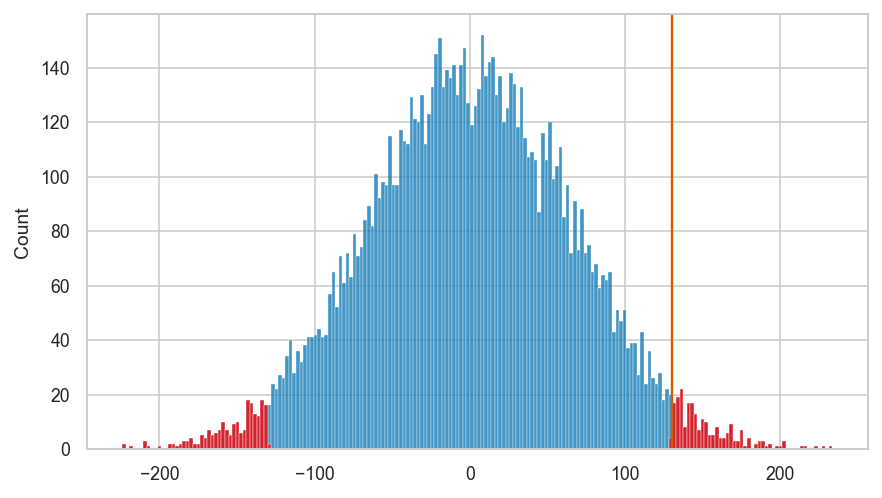

In [33]:
# plot the sampling distribution in blue
sns.histplot(sampling_dist, bins=200)

# plot red line for the observed statistic
obsstat = dmeans(data)
plt.axvline(obsstat, color='r')

# plot the values that are equal or more extreme in red
tailstats = [rs for rs in sampling_dist if rs <= -obsstat or rs >= obsstat]
_ = sns.histplot(tailstats, bins=200, color="red")

- Once we have the sampling distribution of `D` under $H_0$,
  we can see where the observed value $d=130$
  falls within this distribution.
- p-value: the probability of observing value $d=130$ or more extreme under the null hypothesis

In [34]:
pvalue

0.0438

We can now make the decision based on the $p$-value and a pre-determined threshold:

- If the observed value $d$ is unlikely under $H_0$ ($p$-value less than 5% chance of occurring),
  then our decision will be to "reject the null hypothesis."
- Otherwise, if the observed value $d$ is not that unusual ($p$-value greater than 5%),
  we conclude that we have "failed to reject the null hypothesis."

In [35]:
if pvalue < 0.05:
    print("DECISION: Reject H0", "( p-value =", pvalue, ")")
    print("There is a statistically significant difference between xS and xNS")
else:
    print("DECISION: Fail to reject H0")
    print("The difference between groups means could have occurred by chance")    

DECISION: Reject H0 ( p-value = 0.0438 )
There is a statistically significant difference between xS and xNS


#### Permutations test using SciPy

The above code was given only for educational purposes.
In practice, you can use the SciPy implementation of permutation test,
by calling `ttest_ind(..., permutations=10000)` to perform a permutation test, then obtain the $p$-value.

In [36]:
from scipy.stats import ttest_ind

xS = data[data["group"]=="S"]["ELV"]
xNS = data[data["group"]=="NS"]["ELV"]

ttest_ind(xS, xNS, permutations=10000).pvalue

0.0459

Note the $p$-value we obtained form the two methods is slightly different:
this is going to be the case for all resampling methods and simulations,
since use randomness as part of the calculation.

#### Discussion

  - The procedure we used is called a **permutations test** for comparison of group means.
  - The permutation test takes it's name from the action of mixing up the group-membership labels
    and computing a statistic which is a way to generate samples from the null hypothesis
    in situations where we're comparing two groups.
  - Permutation tests are very versatile since we can use them for any estimator $g(\mathbf{x})$.
    For example, we could have used difference in medians by specifying the `median` as the input `statfunc`.


### Summary of Question 1

We saw two ways to answer Question 1 (is there really a difference between group means) and obtain the $p$-value.
We interpreted the small $p$-values as evidence that the observed difference, $d=130$, is unlikely to be due to chance under $H_0$, so we rejected the null hypothesis.
Note this whole procedure is just a sanity check—we haven't touched the alternative hypothesis at all yet,
and for all we know the stats training could have the effect of decreasing ELV!


 
____

It's time to study Question 2, which is to estimate the *magnitude* of the change in ELV obtained from completing the stats training. We call this the *effect size* in statistics.

## Estimating the effect size

- Question 2 of Amy's statistical investigation is to estimate the difference in ELV gained by stats training.
- NEW CONCEPT: **effect size** is a measure of difference between intervention and control groups.
- We assume the data of **Group S** and **Group NS** come from different populations with means $\mu_S$ and $\mu_{NS}$.
- We're interested in estimating the difference between population means, denoted $\Delta = \mu_S - \mu_{NS}$.
- By analyzing the sample, we have obtained an estimate $d=130$ for the unknown $\Delta$,
  but we know our data contains lots of variability, so we know our estimate might be off.
- We want an answer to Question 2 (What is the estimated difference between group means?)
  that takes into account the variability of the data.
- NEW CONCEPT: **confidence interval** is a way to describe a range of values for an estimate
  that takes into account the variability of the data.
- We want to provide an answer to Question 2 in the form of a confidence interval that tells
  us a range of values where we believe the true value of $\Delta$ falls.
- Similar to how we showed two approaches for hypothesis testing,
  we'll work on effect size estimation using two approaches: bootstrap estimation and analytical approximation methods.


### Approach 1: Confidence intervals using bootstrap estimation

- We want to estimate the distribution of ELV values for the two groups,
  and compute the difference between the means of these distributions.
- Distributions:
  - Real sampling distributions: obtained by repeated sampling from the populations
  - Bootstrap sampling distributions: resampling data from the samples we have (with replacement)
- Intuition: treat the samples as if they were the population
- We'll compute $B=5000$ bootstrap samples from the two groups and compute the differences.
  We'll then look at the distribution of the bootstrap sample differences to obtain
  the confidence interval for the difference between population means $CI_{\Delta}$.

In [37]:
def bootstrap_stat(sample, statfunc, B=5000):
    """
    Compute the bootstrap estimate of the function `statfunc`
    from the data in `sample`.
    """
    n = len(sample)
    bstats = []
    for i in range(0, B):
        bsample = np.random.choice(sample, n)
        bstat = statfunc(bsample)
        bstats.append(bstat)
    return bstats

<AxesSubplot:ylabel='Count'>

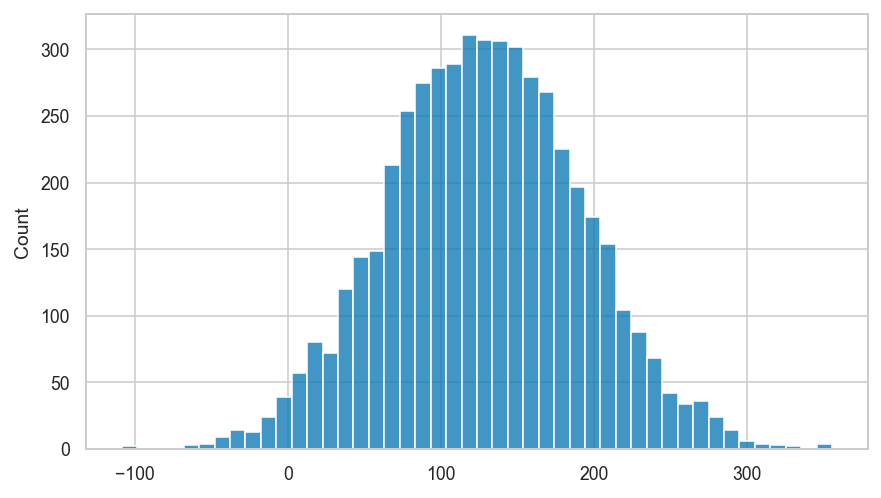

In [38]:
from statistics import mean

# load data for two groups
data = pd.read_csv('../stats_overview/data/employee_lifetime_values.csv')
xS = data[data["group"]=="S"]['ELV']
xNS = data[data["group"]=="NS"]['ELV']

# compute bootstrap estimates for mean in each group
meanS_bstats = bootstrap_stat(xS, statfunc=mean)
meanNS_bstats = bootstrap_stat(xNS, statfunc=mean)

# compute the difference between means from bootstrap samples
dmeans_bstats = []
for bmeanS, bmeanNS in zip(meanS_bstats, meanNS_bstats):
    d = bmeanS - bmeanNS 
    dmeans_bstats.append(d)

sns.histplot(dmeans_bstats)

In [39]:
# 90% confidence interval for the difference in means
CI_boot = [np.percentile(dmeans_bstats, 5),
           np.percentile(dmeans_bstats, 95)]
CI_boot

[23.000091397849218, 233.0627268817204]

The 90% confidence interval `CI_boot` describes an interval of numbers
that should contain the difference between group means $\Delta$ at least 90\% of the time:
$$
    \textrm{Pr}_{R}\big(\{ \Delta \in \textrm{CI}_{\Delta} \}\big) \geq 0.9.
$$
This is a little weird:
in any given experiment,
the unknown difference between groups $\Delta$ either *is* or *isn't* in the interval $\textrm{CI}_{\Delta}$,
so what is 90\% probability referring to?
The randomness $R$ describes repeated experiments using the same calculation procedure for calculating the confidence interval.
So it is not a guarantee on any particular estimate,
but reliability of the procedure in the long term.
This is the *frequentist statistics* paradigm,
in which "quality guarantees" are given about the procedure used to obtain the estimates,
and not about particular outcomes of the procedure.

#### SciPy bootstrap method

In [40]:
from scipy.stats import bootstrap

def dmeans2(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

res = bootstrap((xS, xNS), statistic=dmeans2, vectorized=False,
                confidence_level=0.9, n_resamples=5000, method='percentile')

CI_boot2 = [res.confidence_interval.low, res.confidence_interval.high]
CI_boot2

[26.959781720430346, 232.7994720430106]

## Conclusion of Amy's statistical analysis

Recall the two research questions that Amy set out to answer in the beginning of this video series:

- Question 1: Is there a difference between the means in the two groups?
- Question 2: How much does statistics training improve the ELV of employees?

The statistical analysis we did allows us to answer these two questions as follows:

- Answer 1: There is a statistically significant difference between Group S and Group NS, $p = 0.048$.
- Answer 2: The estimated improvement in ELV is 130 points, which is corresponds to Cohen's d value of $0.52$ (medium effect size). A 90% confidence interval for the true effect size is $[28.4, 237.6]$.

Note: we reported the numerical results obtained from resampling methods (Approach 1), but conclusions would be qualitatively the same if we reported results obtained from analytical approximations (Approach 2).

### Using statistics for convincing others

You may be wondering if all this probabilistic modelling and complicated statistical analysis was worth it to reach a conclusion that seems obvious in retrospect. Was all this work worth it? The purpose of all this work is to obtains something close to an objective conclusion. Without statistics it is very easy to fool ourselves and interpret patterns in data the way we want to, or alternatively, not see patterns that are present. By following the standard statistical procedures, we're less likely to fool ourselves, and more likely to be able to convince others.

It can be very useful to imagine Amy explaining the results to a skeptical colleague. Suppose the colleague is very much against the idea of statistical training, and sees it as a distraction, saying things like "We hire employees to do a job, not to play with Python." and "I don't know any statistics and I'm doing my job just fine!" You get the picture.

Imagine Amy presenting her findings about how 100 hours of statistical training improves employee lifetime value (ELV) results after one year, and suggesting the statistical training be implemented for all new hires from now on. The skeptical colleague immediately rejects the idea and questions Amy's recommendation using emotional appeals about necessity, time wasting, and how statistics is a specialty topic that is not required for all employees. Instead of arguing based on opinions and emotions with her colleague, Amy explains her recommendation is based on a statistical experiment she conducted, and shows the results:

- When the colleague asks if the observed difference could be due to chance, Amy says that this is unlikely, and quotes the $p$-value of 0.048 (less than 0.05), and interprets the result as saying the probability of the observed difference between **Group S** and **Group NS** being due to chance is less than 5%.

- The skeptical colleague is forced to concede that statistical training does improve ELV, but then asks about the effect size of the improvement: "How much more ELV can we expect if we provide statistics training?" Amy is ready to answer quoting the observed difference of $130$ ELV points, and further specifies the 90% confidence interval of $[28.4, 237.6]$ for the improvement, meaning in the worst case there is 28 ELV points improvement.

The skeptic is forced to back down from their objections, and the "stats training for all" program is adopted in the company. Not only was Amy able to win the argument using statistics, but she was also able to set appropriate expectations for the results. In other words, she hasn't promised a guaranteed +130 ELV improvement, but a realistic range of values that can be expected.

## Explanations

### One-sided and two-sided tests

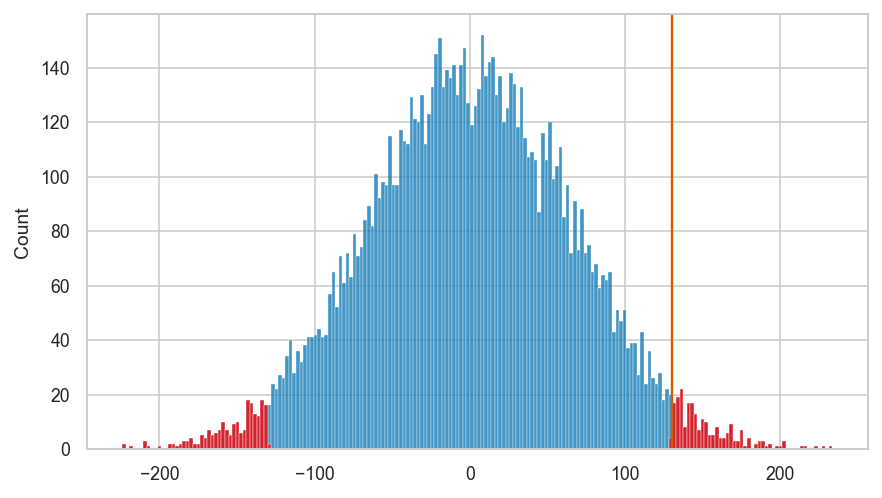

In [41]:
# plot the sampling distribution in blue
sns.histplot(sampling_dist, bins=200)

# plot red line for the observed statistic
obsstat = dmeans(data)
plt.axvline(obsstat, color='r')

# plot the values that are equal or more extreme in red
tailstats = [rs for rs in sampling_dist if rs <= -obsstat or rs >= obsstat]
_ = sns.histplot(tailstats, bins=200, color="red")

Saved figure to figures/stats/NHST/panel_hist_p-values_left_twotailed_right_tests.pdf
Saved figure to figures/stats/NHST/panel_hist_p-values_left_twotailed_right_tests.png


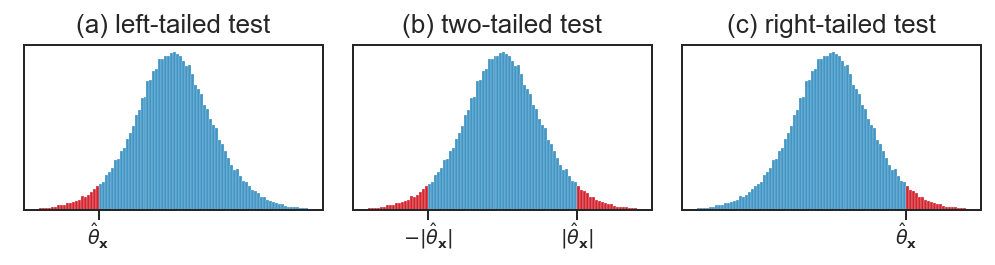

In [42]:
filename = os.path.join(DESTDIR, "panel_hist_p-values_left_twotailed_right_tests.pdf")
    
from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = np.linspace(-4, 4, 100+1)

with plt.rc_context({"figure.figsize":(7,2)}), sns.axes_style("ticks"):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

    # LEFT
    title = '(a) left-tailed test'
    ax1.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax1, bins=bins)
    
    ax1.set_xlim(-4, 4)
    ax1.set_xticks([-2])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_ylabel("")
    # highlight the left tail
    tailstats1 = [t for t in ts if t <= -2]
    sns.histplot(tailstats1, bins=bins, ax=ax1, color="red")
    ax1.text(-2, -200, r"$\hat{\theta}_{\mathbf{x}}$", va="top", ha="center")


    # TWO-TAILED
    title = '(b) two-tailed test'
    ax2.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax2, bins=bins)
    ax2.set_xlim(-4, 4)
    ax2.set_xticks([-2,2])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    # highlight the left and right tails
    tailstats2 = [t for t in ts if t <= -2 or t >= 2]
    sns.histplot(tailstats2, bins=bins, ax=ax2, color="red")
    ax2.text(-2, -200, r"$-|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")
    ax2.text(2, -200, r"$|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")


    # RIGHT
    title = '(c) right-tailed test'
    ax3.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax3, bins=bins)
    ax3.set_xlim(-4, 4)
    ax3.set_xticks([2])
    ax3.set_xticklabels([])
    ax3.set_yticks([])
    # highlight the right tail
    tailstats3 = [t for t in ts if t >= 2]
    sns.histplot(tailstats3, bins=bins, ax=ax3, color="red")
    ax3.text(2, -200, "$\hat{\\theta}_{\mathbf{x}}$", verticalalignment="top", horizontalalignment="center")

savefigure(fig, filename)

## Discussion